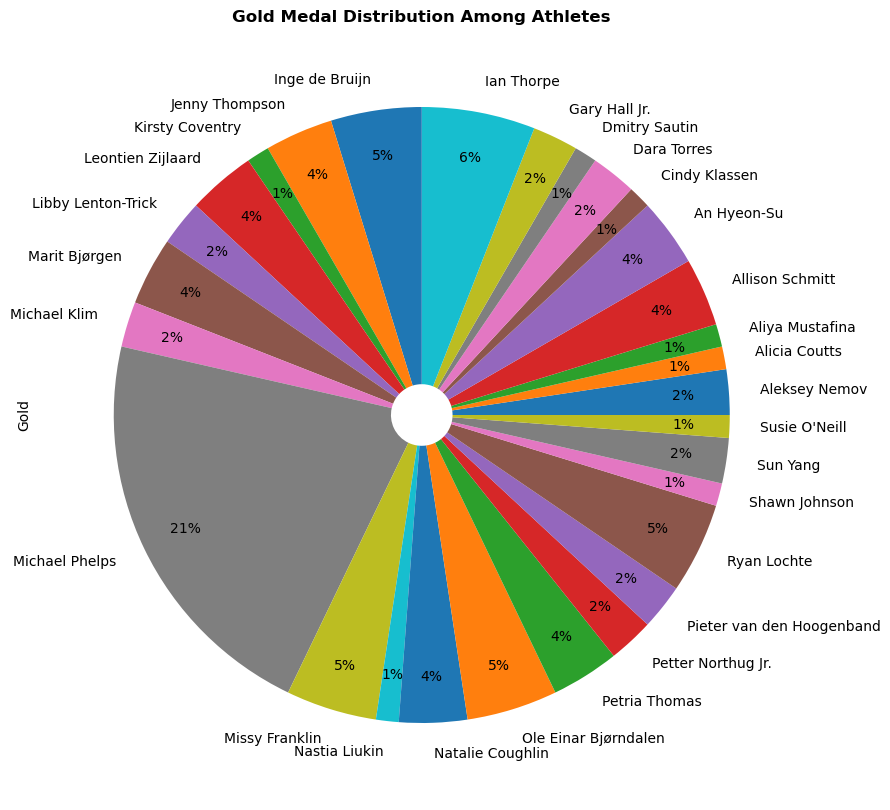

Animation saved successfully at C:\Users\r tech\Desktop\athletes.gif


OSError: Address 'http://127.0.0.1:8050' already in use.
    Try passing a different port to run_server.

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
import os

def prepare_data(filepath):
    df = pd.read_excel(filepath, skiprows=1)
    df.columns = ["Age", "Silver", "Bronze", "Athlete", "Date", "Gold", "Sport", "Country"]
    df['Gold'] = pd.to_numeric(df['Gold'], errors='coerce').fillna(0).astype(int)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    return df


def create_pie_chart(df):
    gold_counts = df.groupby("Athlete")['Gold'].sum()
    gold_counts = gold_counts[gold_counts > 0]
    gold_counts.plot(kind="pie",
                     autopct="%.0f%%",  
                     figsize=(10, 10),  
                     wedgeprops=dict(width=0.9),  
                     pctdistance=0.85)
    plt.title("Gold Medal Distribution Among Athletes", fontweight="bold")  
    plt.show()



    
def update_bar_graph(i, data, bars, txts, title_txt):
    y = data.iloc[i, :]
    title_txt.set_text(f"Date: {data.index[i].date()}")
    for j, b in enumerate(bars.patches):
        b.set_width(y.iloc[j])
        txts[j].set_text(f"{y.iloc[j].astype(int)}")
        txts[j].set_x(y.iloc[j] + data.max().max() * 0.01)




def animated_bar_graph(df, frames_per_step=10, output_path="C:\\Users\\r tech\\Desktop\\athletes.gif"):
    df.set_index('Date', inplace=True)
    cumulative_df = df.groupby([df.index, 'Athlete'])['Gold'].sum().groupby(level=1).cumsum().unstack().fillna(0)

    selected = cumulative_df.iloc[-1].sort_values(ascending=False)[:20].index
    data = cumulative_df[selected].round()

    fig, ax = plt.subplots(figsize=(9.3, 5))
    fig.subplots_adjust(left=0.25)
    no_of_frames = data.shape[0]

    bars = sns.barplot(y=data.columns, x=data.iloc[0], orient="h", ax=ax)
    ax.set_xlim(0, data.max().max() * 1.1)

    txts = [ax.text(0, i, 0, va="center") for i in range(data.shape[1])]
    title_txt = ax.text(data.max().max() * 0.5, -1, "Date: ", fontsize=12)

    anim = FuncAnimation(fig, update_bar_graph, fargs=(data, bars, txts, title_txt),
                         repeat=False, frames=no_of_frames, interval=100, blit=False)

    try:
       
        anim.save(output_path, writer=PillowWriter(fps=30))
        print(f"Animation saved successfully at {os.path.abspath(output_path)}")
    except Exception as e:
        print(f"Error saving animation: {e}")

    plt.close(fig)

def create_dash_app(df):
    df_grouped = df.groupby(['Country', 'Date'])[['Gold', 'Silver', 'Bronze']].sum().reset_index()

    app = dash.Dash(__name__)

    app.layout = html.Div([
        html.H1("Olympic Medals Dashboard"),
        dcc.Dropdown(id='country-dropdown',
                     options=[{'label': country, 'value': country} for country in df['Country'].unique()],
                     value='USA'),
        dcc.Graph(id='medals-graph')
    ])

    @app.callback(
        Output('medals-graph', 'figure'),
        [Input('country-dropdown', 'value')]
    )
    def update_graph(selected_country):
        filtered_df = df_grouped[df_grouped['Country'] == selected_country]
        if filtered_df.empty:
            fig = px.bar(title=f"No data available for {selected_country}")
        else:
            fig = px.bar(filtered_df, x='Date', y=['Gold', 'Silver', 'Bronze'],
                         title=f"Medal Count for {selected_country}",
                         labels={'value': 'Medals', 'Date': 'Year'},
                         barmode='stack')
        return fig

    return app


if __name__ == '__main__':
    filepath = r"G:\data science\harvard project\New Microsoft Excel Worksheet.xlsx"
    df = prepare_data(filepath)
    create_pie_chart(df)
    animated_bar_graph(df)  
    app = create_dash_app(df)
    app.run_server(debug=True)
